In [1]:
%matplotlib inline
import sys
#BIN = '../'
#sys.path.append(BIN)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
#import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
from torch.autograd import Variable

from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

#import my_matplotlib_style as ms

from fastai import data_block, basic_train, basic_data
from fastai.callbacks import ActivationStats
import fastai

import matplotlib as mpl
#mpl.rc_file(BIN + 'my_matplotlib_rcparams')


In [2]:
from HEPAutoencoders.nn_utils import AE_big, AE_3D_200
from HEPAutoencoders.utils import plot_activations

In [3]:
torch.cuda.is_available()

False

In [4]:
#fastai.torch_core.defaults.device = 'cuda'

In [6]:
# Load data
train = pd.read_pickle('processed_data/train.pkl')
test = pd.read_pickle('processed_data/test.pkl')
n_features = len(train.loc[0])

train.head(10)

,pT,eta,phi,E
1367643,300.752869,0.118391,-1.460827,303.719818
1739612,79.819145,4.535507,-1.185196,3722.832764
546066,220.472305,1.314261,-0.943992,440.195190
213212,74.533775,0.010658,-0.424795,74.770332
150544,220.668121,2.432910,-2.308348,1266.681030
574837,159.841782,0.731125,-1.150598,207.133514
1171687,306.125305,0.702473,0.437615,385.713013
1608254,189.011673,-1.387443,0.490634,403.126709
1618830,194.996719,-1.022815,-1.560437,306.534515
637947,186.887146,-0.621282,-0.465523,226.002701


<Figure size 432x288 with 0 Axes>

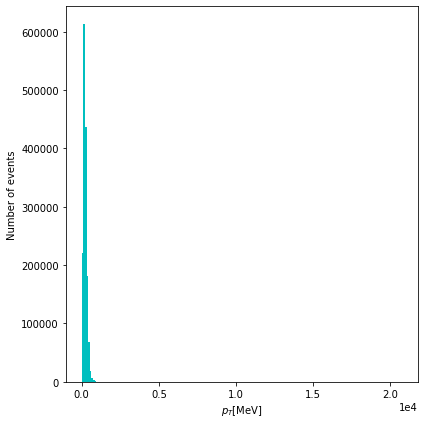

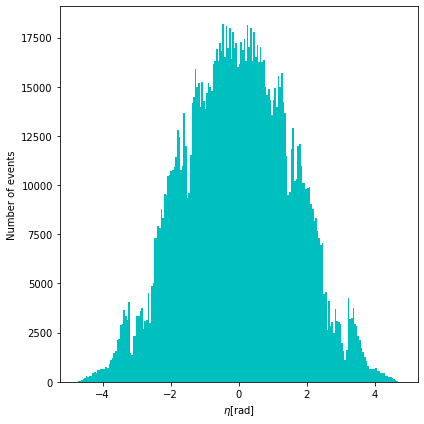

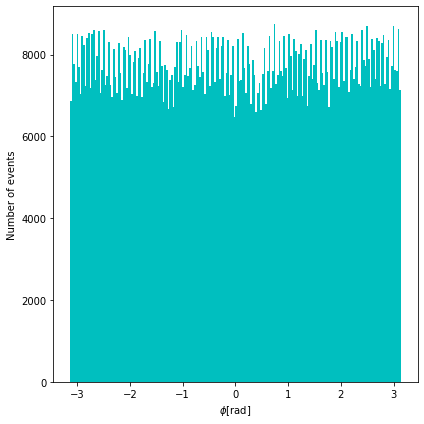

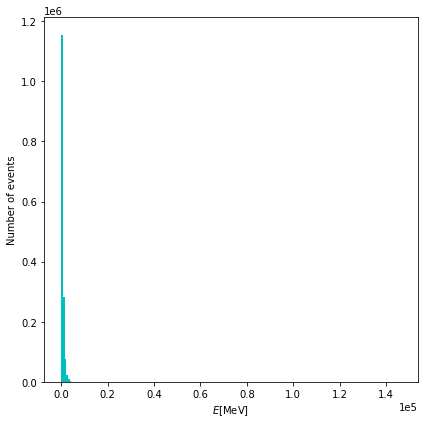

In [9]:
import matplotlib.pyplot as plt
import numpy as np

plt.close('all')
unit_list = ['[MeV]', '[rad]', '[rad]', '[MeV]']
variable_list = [r'$p_T$', r'$\eta$', r'$\phi$', r'$E$']
line_style = ['--', '-']
colors = ['orange', 'c']
markers = ['*', 's']

branches=["pT","eta","phi","E"]

%matplotlib inline
n_bins = 200
alph = 0.8
#for kk in np.arange(4):
for kk in [0,1,2,3]:
    plt.figure(kk + 4)
    plt.figure(figsize=(6,6))
    plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
    n_hist_data, bin_edges, _ = plt.hist(train[branches[kk]], color=colors[1], label='Input', alpha=1, bins=n_bins)
    #n_hist_pred, _, _ = plt.hist(pred[:, kk], color=colors[0], label='Output', alpha=alph, bins=bin_edges)
    #plt.suptitle(branches[kk])
    plt.xlabel(variable_list[kk] + unit_list[kk])
    plt.ylabel('Number of events')
    #ms.sciy()
    #plt.xlim(0, 0.25*1e4)
    # plt.yscale('log')
    #plt.legend(loc=4)
    fig_name = 'trainforever_hist_%s' % train.columns[kk]
    plt.tight_layout()

In [10]:
# Normalize
train_mean = train.mean()
train_std = train.std()

train = (train - train_mean) / train_std
test = (test - train_mean) / train_std

train_x = train
test_x = test
train_y = train_x  # y = x since we are building and AE
test_y = test_x

train_ds = TensorDataset(torch.tensor(train_x.values), torch.tensor(train_y.values))
valid_ds = TensorDataset(torch.tensor(test_x.values), torch.tensor(test_y.values))

<Figure size 432x288 with 0 Axes>

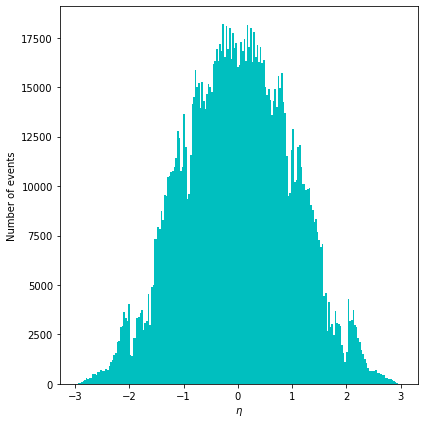

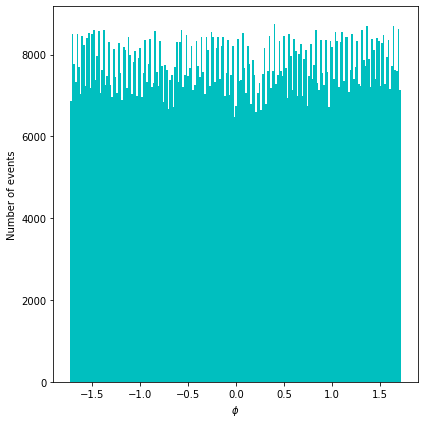

In [12]:
plt.close('all')
unit_list = ['[MeV]', '[rad]', '[rad]', '[MeV]']
variable_list = [r'$p_T$', r'$\eta$', r'$\phi$', r'$E$']
line_style = ['--', '-']
colors = ['orange', 'c']
markers = ['*', 's']

branches=["pT","eta","phi","E"]

%matplotlib inline
n_bins = 200
alph = 0.8
#for kk in np.arange(4):
for kk in [1,2]:
    plt.figure(kk + 4)
    plt.figure(figsize=(6,6))
    #plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
    n_hist_data, bin_edges, _ = plt.hist(train[branches[kk]], color=colors[1], label='Input', alpha=1, bins=n_bins)
    #n_hist_pred, _, _ = plt.hist(pred[:, kk], color=colors[0], label='Output', alpha=alph, bins=bin_edges)
    #plt.suptitle(branches[kk])
    plt.xlabel(variable_list[kk])
    plt.ylabel('Number of events')
    #ms.sciy()
    #plt.xlim(-5, 10)
    # plt.yscale('log')
    #plt.legend(loc=4)
    fig_name = 'trainforever_hist_%s' % train.columns[kk]
    plt.tight_layout()

In [13]:
def get_data(train_ds, valid_ds, bs):
    return (
        DataLoader(train_ds, batch_size=bs, shuffle=True),
        DataLoader(valid_ds, batch_size=bs * 2),
    )

In [14]:
train_dl, valid_dl = get_data(train_ds, valid_ds, bs=256)

In [15]:
db = basic_data.DataBunch(train_dl, valid_dl)

In [16]:
db

DataBunch;

Train: <torch.utils.data.dataset.TensorDataset object at 0x7f0f7e5ff240>;

Valid: <torch.utils.data.dataset.TensorDataset object at 0x7f0f7fe404e0>;

Test: None

In [17]:
model = AE_3D_200()


In [18]:
loss_func = nn.MSELoss()

In [19]:
bn_wd = False  # Don't use weight decay fpr batchnorm layers
true_wd = True  # wd will be used for all optimizers
wd = 1e-6
#wd = 0
learn = basic_train.Learner(data=db, model=model, loss_func=loss_func, wd=wd, callback_fns=ActivationStats, bn_wd=bn_wd, true_wd=true_wd)

In [20]:
from fastai import train as tr
tr.lr_find(learn)

epoch,train_loss,valid_loss,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


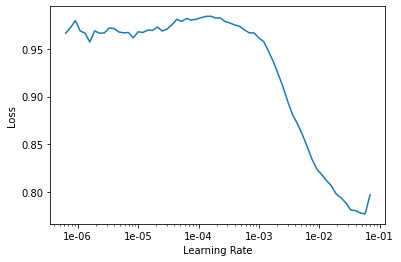

In [21]:
learn.recorder.plot()

In [25]:
lr = 1e-7
learn.fit(10, lr=lr, wd=wd)

epoch,train_loss,valid_loss,time
0,0.963715,0.957496,01:42
1,0.956180,0.937241,01:41
2,0.920763,0.911472,01:41
3,0.888341,0.880748,01:41
4,0.845356,0.845965,01:42
5,0.804855,0.808168,01:42
6,0.771198,0.768456,01:42
7,0.735747,0.727916,01:42
8,0.686793,0.687446,01:41
9,0.648095,0.647647,01:42


In [26]:
lr = 1e-4
learn.fit(10, lr=lr, wd=wd)

epoch,train_loss,valid_loss,time
0,0.000310,0.000410,01:42
1,0.342349,0.000960,01:41
2,0.000071,0.000091,01:41
3,0.000346,0.000109,01:42
4,0.000049,0.000047,01:43
5,0.000040,0.000029,01:42
6,0.000039,0.000030,01:43
7,0.000093,0.000049,01:42
8,0.000041,0.000044,01:42
9,0.000042,0.000046,01:42


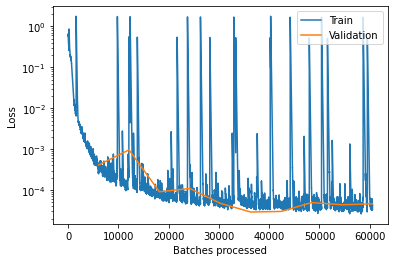

In [27]:
learn.recorder.plot_losses()
plt.yscale('log')

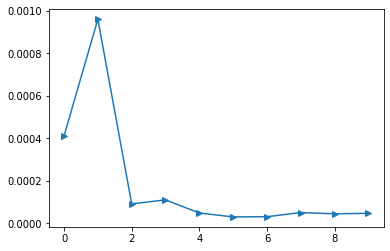

In [28]:
plt.plot(learn.recorder.val_losses, marker='>')

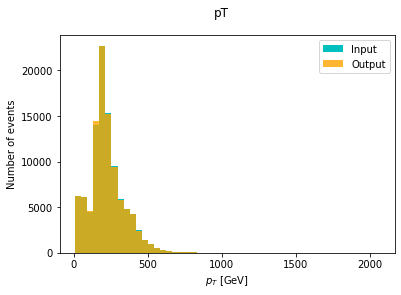

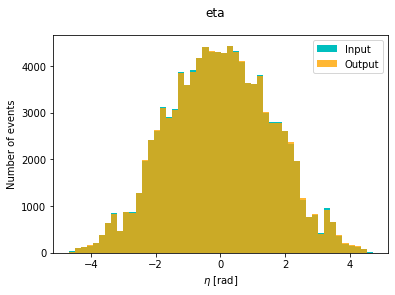

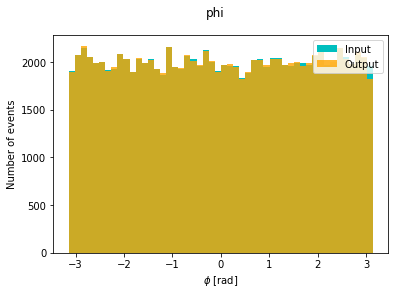

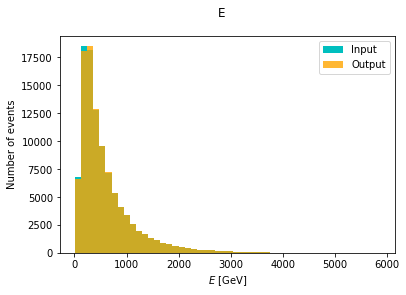

In [30]:
plt.close('all')
unit_list = ['[GeV]', '[rad]', '[rad]', '[GeV]']
variable_list = [r'$p_T$', r'$\eta$', r'$\phi$', r'$E$']
line_style = ['--', '-']
colors = ['orange', 'c']
markers = ['*', 's']

model.to('cpu')

# Histograms
idxs = (0, 100000)  # Choose events to compare
data = torch.tensor(test_x[idxs[0]:idxs[1]].values)
pred = model(data).detach().numpy()
pred = np.multiply(pred, train_std.values)
pred = np.add(pred, train_mean.values)
data = np.multiply(data, train_std.values)
data = np.add(data, train_mean.values)

alph = 0.8
n_bins = 50
for kk in np.arange(4):
    plt.figure(kk + 4)
    n_hist_data, bin_edges, _ = plt.hist(data[:, kk], color=colors[1], label='Input', alpha=1, bins=n_bins)
    n_hist_pred, _, _ = plt.hist(pred[:, kk], color=colors[0], label='Output', alpha=alph, bins=bin_edges)
    plt.suptitle(train_x.columns[kk])
    plt.xlabel(variable_list[kk] + ' ' + unit_list[kk])
    plt.ylabel('Number of events')
    #ms.sciy()
    # plt.yscale('log')
    plt.legend()
    fig_name = 'trainforever_hist_%s' % train.columns[kk]
    #plt.savefig(curr_save_folder + fig_name)

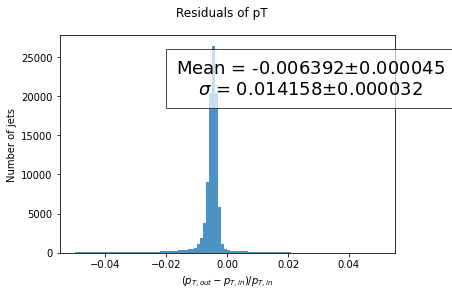

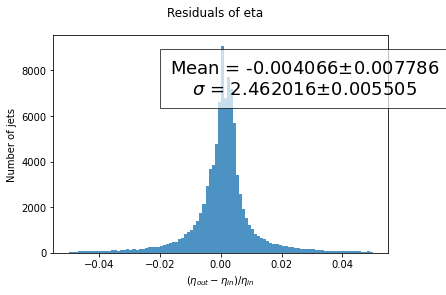

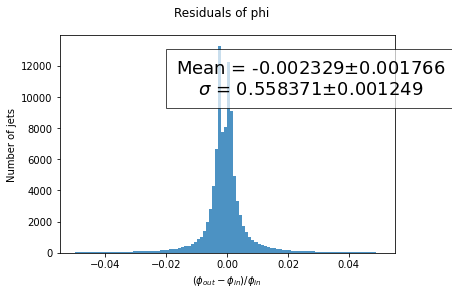

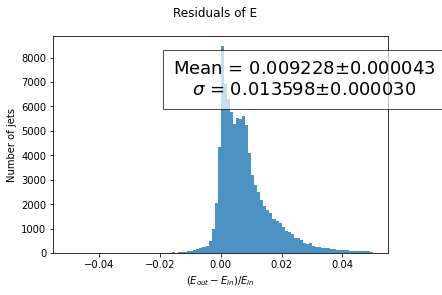

In [34]:
import HEPAutoencoders.utils as utils
from scipy import stats
residual_strings = [r'$(p_{T,out} - p_{T,in}) / p_{T,in}$',
                        r'$(\eta_{out} - \eta_{in}) / \eta_{in}$',
                        r'$(\phi_{out} - \phi_{in}) / \phi_{in}$',
                        r'$(E_{out} - E_{in}) / E_{in}$']
residuals = (pred - data.detach().numpy()) / data.detach().numpy()
axisrange = (-.05, .05)
#range=None
for kk in np.arange(4):
    plt.figure()
    n_hist_pred, bin_edges, _ = plt.hist(
        residuals[:, kk], label='Residuals', linestyle=line_style[0], alpha=alph, bins=100, range=axisrange)
    plt.suptitle('Residuals of %s' % train.columns[kk])
    plt.xlabel(residual_strings[kk])  # (train.columns[kk], train.columns[kk], train.columns[kk]))
    plt.ylabel('Number of jets')
    #ms.sciy()
    #plt.yscale('log')
    std = np.std(residuals[:, kk])
    std_err = utils.std_error(residuals[:, kk])
    mean = np.nanmean(residuals[:, kk])
    sem = stats.sem(residuals[:, kk], nan_policy='omit')
    ax = plt.gca()
    plt.text(.75, .8, 'Mean = %f$\pm$%f\n$\sigma$ = %f$\pm$%f' % (mean, sem, std, std_err), bbox={'facecolor': 'white', 'alpha': 0.7, 'pad': 10},
             horizontalalignment='center', verticalalignment='center', transform=ax.transAxes, fontsize=18)
    fig_name = 'trainforever_residual_%s' % train.columns[kk]
    #plt.savefig(curr_save_folder + fig_name)

In [35]:
import corner.corner as corner
import seaborn as sns

res_df = pd.DataFrame({'pt': residuals[:, 0], 'eta': residuals[:, 1], 'phi': residuals[:, 2], 'E': residuals[:, 3]})
save = False

# Generate a custom diverging colormap
cmap = sns.diverging_palette(10, 220, as_cmap=True)
#cmap = 'RdBu'
norm = mpl.colors.Normalize(vmin=-1, vmax=1, clip=False)
mappable = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)

group = ['pt', 'eta', 'phi', 'E']

label_kwargs = {'fontsize': 20}
title_kwargs = {"fontsize": 11}
mpl.rcParams['lines.linewidth'] = 1
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
group_arr = res_df.values
corr = res_df.corr()
qs = np.quantile(group_arr, q=[.0025, .9975], axis=0)
ndim = qs.shape[1]
ranges = [tuple(qs[:, kk]) for kk in np.arange(ndim)]
figure = corner(group_arr, range=ranges, plot_density=True, plot_contours=True, no_fill_contours=False, #range=[range for i in np.arange(ndim)],
                bins=50, labels=group, label_kwargs=label_kwargs, #truths=[0 for kk in np.arange(qs.shape[1])],
                show_titles=True, title_kwargs=title_kwargs, quantiles=(0.16, 0.84),
                # levels=(1 - np.exp(-0.5), .90), fill_contours=False, title_fmt='.2e')
                levels=(1 - np.exp(-0.5), .90), fill_contours=False, title_fmt='.1e')

# # Extract the axes
axes = np.array(figure.axes).reshape((ndim, ndim))
# Loop over the diagonal
linecol = 'r'
linstyl = 'dashed'
# Loop over the histograms
for yi in np.arange(ndim):
    for xi in np.arange(yi):
        ax = axes[yi, xi]
        # Set face color according to correlation
        ax.set_facecolor(color=mappable.to_rgba(corr.values[yi, xi]))
cax = figure.add_axes([.87, .4, .04, 0.55])
cbar = plt.colorbar(mappable, cax=cax, format='%.1f', ticks=np.arange(-1., 1.1, 0.2))
cbar.ax.set_ylabel('Correlation', fontsize=20)

if save:
    fig_name = 'corner_3d.png'
    plt.savefig(curr_save_folder + fig_name)

ModuleNotFoundError: No module named 'corner'